# 线性回归+基础优化算法
## 线性回归从0开始实现

我们将从零实现整个方法，包括数据流水线，模型，损失函数，和小批量随机梯度下降优化器

In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

构造带有噪声的线性模型构造一个人造数据集，我们使用线性模型参数w=（2，-3.4）^T，b=4.2和噪声项e生成数据集及其标签：y=X*w+b+e

In [5]:
def synthetic_data(w,b,num_examples):
    """生成 y=X*w+b+噪声。"""
    X = torch.normal(0,1,(num_examples,len(w)))
    y = torch.matmul(X,w)+b
    y += torch.normal(0,0.01,y.shape)
    return X,y.reshape((-1,1))# 是变成一列的意思

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)
print('features:',features[0],'\nlabel:',labels[0])

features: tensor([-0.0871, -0.1788]) 
label: tensor([4.6464])


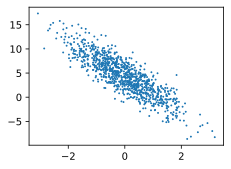

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),
                labels.detach(),1)

定义一个data_iter函数，该函数接收批量大小，特征矩阵和标签向量作为输入，生成大小为batch_size的小批量

In [29]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)# 把下标打乱
    for i in range(0,num_examples,batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]
batch_size = 10
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[ 0.0574,  0.6089],
        [ 0.1622,  0.4583],
        [ 0.0818, -0.6723],
        [-0.2497,  1.0055],
        [-0.7880, -1.6557],
        [ 0.6682,  0.9292],
        [ 0.7685, -0.3353],
        [ 0.5216,  0.2542],
        [ 0.2630, -0.4140],
        [-0.1179,  0.9867]]) 
 tensor([[2.2514],
        [2.9527],
        [6.6423],
        [0.2773],
        [8.2610],
        [2.3855],
        [6.8855],
        [4.3787],
        [6.1342],
        [0.6158]])


定义初始化模型参数

In [30]:
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

定义模型

In [31]:
def linreg(X,w,b):
    """线性回归模型"""
    return torch.matmul(X,w)+b # matmul进行矩阵乘向量计算

定义损失函数

In [32]:
def squared_loss(y_hat,y):# y_hat为预测值
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape))**2/2

定义优化算法

In [33]:
def sgd(params,lr,batch_size):# params包含w和b，lr是学习率，batch_size是小批量大小
    """小批量随机梯度下降"""
    with torch.no_grad():# 不用计算梯度
        for param in params:
            param -= lr*param.grad/batch_size
            param.grad.zero_()

训练过程

In [34]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y)# x,y的小批量损失
        # 因为l的形状是(batch_size,1)，而不是一个标量，l中的所有元素被加到一起
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w,b],lr,batch_size)#使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch {epoch+1},loss {float(train_l.mean()):f}')
        

epoch 1,loss 0.028567
epoch 2,loss 0.000109
epoch 3,loss 0.000054


比较真实参数和通过训练学到的参数来估计训练的成功程度

In [35]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([-0.0004, -0.0005], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0008], grad_fn=<RsubBackward1>)
